In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import ParameterGrid

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.ae_eval_and_vis import *
#from utils.ae_torch_classes import *
from utils.ae_V2_dropout import *

# Load in Data

In [2]:
from utils.data_loading_paths import *

kai_laptop = True
brc_desktop = False

if kai_laptop:
    data_path = kai_data_path
    model_dir_path = kai_model_dir_path
    metadata_path = kai_metadata_path
elif brc_desktop:
    data_path = brc_data_path
    model_dir_path = brc_model_dir_path
    metadata_path = brc_metadata_path

metadata_cols_df = pd.read_pickle(metadata_path)

# Dropping the metadata when we read it in!
training_users_df = pd.read_pickle(data_path+both_pca40_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
test_users_df = pd.read_pickle(data_path+both_pca40_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

In [3]:
print(training_users_df.shape)
training_users_df.head()

(160000, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.030730,-0.052976,0.176556,-0.048078,-0.390790,-2.119829,0.875118,-0.187689,0.685004,0.870080,...,-0.253283,-0.248582,0.283079,-0.178321,-0.087101,-0.027081,0.000970,0.124380,-0.100580,-0.119294
1,0.077533,-0.108477,0.128970,-0.032167,-0.182756,-1.604412,0.701500,-0.068443,0.667338,1.098287,...,-0.423007,0.097453,0.184025,0.027788,0.112078,-0.414946,-0.210576,0.277156,0.051190,-0.039548
2,0.268279,-0.369027,0.268750,0.105239,-0.190292,-2.093812,1.012038,-0.080958,0.510502,0.758940,...,-0.311882,0.138655,-0.067485,0.201313,-0.051898,-0.479894,-0.079818,0.398142,0.058779,-0.095208
3,-0.106155,-0.291958,0.270681,0.035371,-0.204143,-2.314179,0.801514,-0.155267,0.519967,0.523683,...,-0.585487,-0.100021,0.082335,0.042349,-0.179251,-0.106235,-0.034940,0.386797,-0.034177,-0.132103
4,0.673338,-0.345606,0.246740,0.238184,0.948365,-0.041183,0.279347,0.034288,1.173712,2.115719,...,-0.262556,0.011353,-0.353489,0.209535,-0.402682,-0.353866,0.106203,0.366540,0.218785,-0.080414


In [4]:
# CREATE THE TRAINING SET
num_rows_per_gesture = 64 # From the interp
num_gestures = len(training_users_df) // num_rows_per_gesture
num_features = training_users_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(training_users_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
X_3D_PCA40 = training_users_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_features)
#flattened_PCA = PCA_np.reshape(num_gestures, -1)

# Convert to PyTorch tensor
X_3DTensor_PCA40 = torch.tensor(X_3D_PCA40, dtype=torch.float32)

# Dummy dataset
#data = torch.randn(num_gestures, timesteps, num_features)
#dataset = TensorDataset(data)
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Create the dataset
u_training_dataset = GestureDatasetAE(X_3DTensor_PCA40)

batch_size = 32  # Adjust batch size as needed
train_loader = DataLoader(u_training_dataset, batch_size=batch_size, shuffle=True) # Should shuffle be False? 
## It's shuffling the gesture order I think so that should be fine...

# CREATE THE TEST SET
num_test_gestures = len(test_users_df) // num_rows_per_gesture
# Ensure the data can be evenly divided into gestures
assert len(test_users_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns) and convert to torch tensor
## Theres probably an easier way to just create it as a torch tensor lol
Xtest_3DTensor_PCA40 = torch.tensor(test_users_df.to_numpy().reshape(num_test_gestures, num_rows_per_gesture, num_features), dtype=torch.float32)

# Create the dataset
u_testing_dataset = GestureDatasetAE(Xtest_3DTensor_PCA40)
test_loader = DataLoader(u_testing_dataset, batch_size=batch_size, shuffle=False)

# RNN Autoencoder

In [5]:
# Example usage
input_dim = 40
#num_features = 40
seq_len = 64
#timesteps = 64
criterion = nn.MSELoss()
num_epochs = 10

## Manual Grid Search

Started
Epoch 0: Train Loss: 1.822920880740202;  Validation Loss: 1.4892536889423023
Epoch 1: Train Loss: 1.518179321590858;  Validation Loss: 1.3354772573167628
Epoch 2: Train Loss: 1.4106800571272644;  Validation Loss: 1.2497749707915566
Epoch 3: Train Loss: 1.3355949302262897;  Validation Loss: 1.1662330573255366
Epoch 4: Train Loss: 1.2694820829584628;  Validation Loss: 1.0976434783502058
Epoch 5: Train Loss: 1.218051427527319;  Validation Loss: 1.0522245222871953
Epoch 6: Train Loss: 1.1813783192936378;  Validation Loss: 1.0188488933173092
Epoch 7: Train Loss: 1.1606300692015057;  Validation Loss: 0.9999894174662504
Epoch 8: Train Loss: 1.1378300340869758;  Validation Loss: 0.9778062457388098
Epoch 9: Train Loss: 1.121308070194872;  Validation Loss: 0.9641244926235892


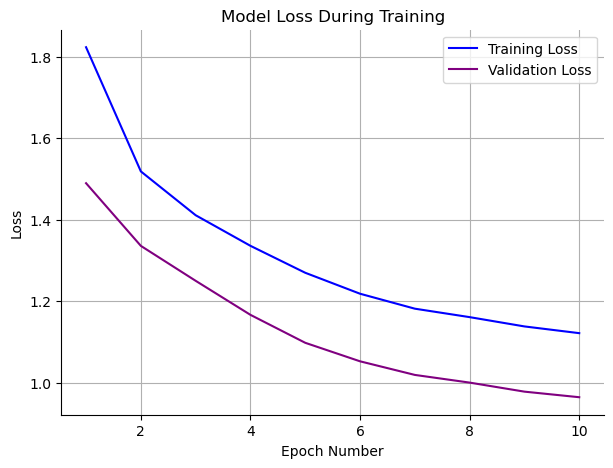

In [6]:
print("Started")

# Hyperparameters and dataset setup
num_layers = 3
lr = 0.001
hidden_dim = 56

# With progressive halving
model_56_nl3_prog, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim, num_layers, train_loader, test_loader, progressive_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 1.868023784854744;  Validation Loss: 1.5909053033048457
Epoch 1: Train Loss: 1.5954945751383334;  Validation Loss: 1.3947148892012509
Epoch 2: Train Loss: 1.4692800980580003;  Validation Loss: 1.3123572902245955
Epoch 3: Train Loss: 1.4006519106369983;  Validation Loss: 1.249446373094212
Epoch 4: Train Loss: 1.3494263706327994;  Validation Loss: 1.20068805326115
Epoch 5: Train Loss: 1.3186623884152762;  Validation Loss: 1.178801948373968
Epoch 6: Train Loss: 1.2951969074297556;  Validation Loss: 1.1638891453092748
Epoch 7: Train Loss: 1.2783443414712254;  Validation Loss: 1.1477474082599988
Epoch 8: Train Loss: 1.26476104953621;  Validation Loss: 1.1379083882678638
Epoch 9: Train Loss: 1.2585427157486542;  Validation Loss: 1.1225798265500502


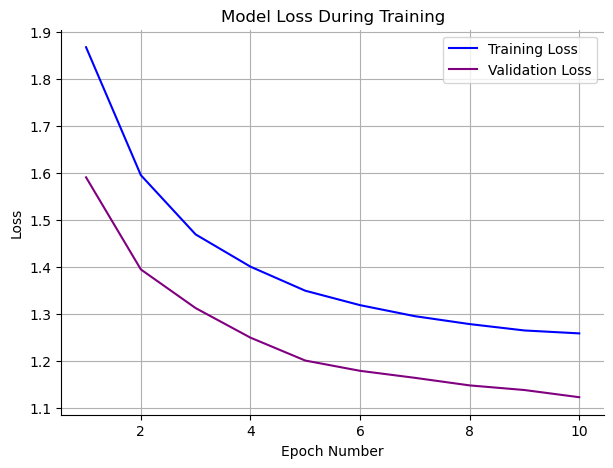

In [7]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001
hidden_dim_list = [56, 28, 14]

# With mirroring
model_56_28_14mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 2.0649889103973966;  Validation Loss: 1.9319888082417576
Epoch 1: Train Loss: 1.9180137598061864;  Validation Loss: 1.7892173691229387
Epoch 2: Train Loss: 1.848617079891736;  Validation Loss: 1.7136721448464827
Epoch 3: Train Loss: 1.8040720480906813;  Validation Loss: 1.6598497087305242
Epoch 4: Train Loss: 1.7646777554403377;  Validation Loss: 1.6449969519268384
Epoch 5: Train Loss: 1.7467412601543377;  Validation Loss: 1.6278355121612549
Epoch 6: Train Loss: 1.72933354558824;  Validation Loss: 1.6167000098661943
Epoch 7: Train Loss: 1.7175872024101546;  Validation Loss: 1.5948848832737317
Epoch 8: Train Loss: 1.7078852955299089;  Validation Loss: 1.5870217680931091
Epoch 9: Train Loss: 1.694268208515795;  Validation Loss: 1.5756656527519226


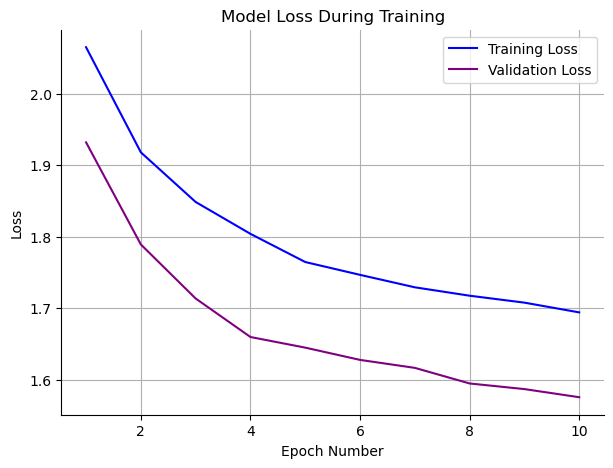

In [8]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [32, 16, 8, 3]
model_32_16_8_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 2.01967618435244;  Validation Loss: 1.8418554934588345
Epoch 1: Train Loss: 1.867149085938176;  Validation Loss: 1.7313721017404036
Epoch 2: Train Loss: 1.8051680718796164;  Validation Loss: 1.6721629933877424
Epoch 3: Train Loss: 1.763427483884594;  Validation Loss: 1.6305268623612144
Epoch 4: Train Loss: 1.7389786862119843;  Validation Loss: 1.6097918423739346
Epoch 5: Train Loss: 1.7242541705505758;  Validation Loss: 1.5962033055045388
Epoch 6: Train Loss: 1.7155101193657405;  Validation Loss: 1.5843038233843716
Epoch 7: Train Loss: 1.706485754326929;  Validation Loss: 1.5765307762406089
Epoch 8: Train Loss: 1.698600615127177;  Validation Loss: 1.5688762339678677
Epoch 9: Train Loss: 1.6895237270789811;  Validation Loss: 1.5662527734583074


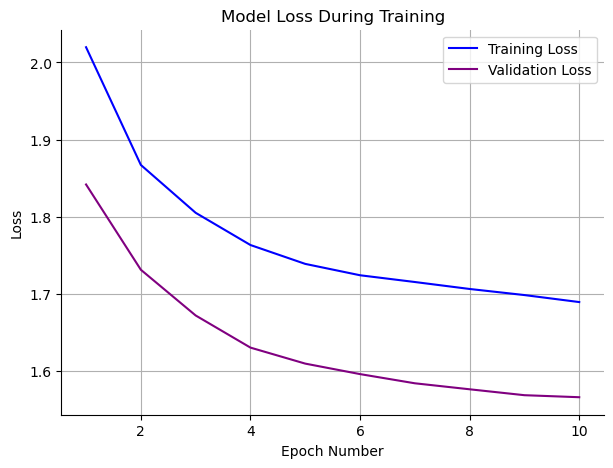

In [9]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [32, 16, 3]
model_32_16_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 1.9621720917617218;  Validation Loss: 1.7518586137078025
Epoch 1: Train Loss: 1.7884377799456632;  Validation Loss: 1.6339924010363491
Epoch 2: Train Loss: 1.7104826712910133;  Validation Loss: 1.5756046555259011
Epoch 3: Train Loss: 1.665161612667615;  Validation Loss: 1.5403857122768054
Epoch 4: Train Loss: 1.6264672566063796;  Validation Loss: 1.5047859359871258
Epoch 5: Train Loss: 1.5958722271496737;  Validation Loss: 1.4578052813356572
Epoch 6: Train Loss: 1.5698160249975663;  Validation Loss: 1.4290189309553667
Epoch 7: Train Loss: 1.5388075128386292;  Validation Loss: 1.4034414183009754
Epoch 8: Train Loss: 1.5130399209034593;  Validation Loss: 1.3705602477897296
Epoch 9: Train Loss: 1.4929517930067038;  Validation Loss: 1.3540952422402122


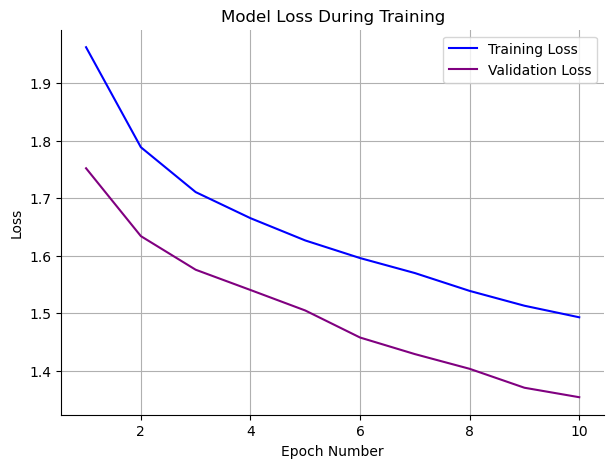

In [10]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [56, 28, 3]
model_56_28_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 1.9343499760084515;  Validation Loss: 1.7031031250953674
Epoch 1: Train Loss: 1.6953040059608748;  Validation Loss: 1.5297180034897544
Epoch 2: Train Loss: 1.5721825708316852;  Validation Loss: 1.421080388806083
Epoch 3: Train Loss: 1.4911897786055939;  Validation Loss: 1.3515246320854535
Epoch 4: Train Loss: 1.4353544802605351;  Validation Loss: 1.2959916916760532
Epoch 5: Train Loss: 1.3885449910465675;  Validation Loss: 1.2486467469822278
Epoch 6: Train Loss: 1.3522709487359734;  Validation Loss: 1.2079245041717181
Epoch 7: Train Loss: 1.3210774705379824;  Validation Loss: 1.1645966497334568
Epoch 8: Train Loss: 1.2963155462772031;  Validation Loss: 1.1392301131378522
Epoch 9: Train Loss: 1.2785618290116516;  Validation Loss: 1.1177277835932644


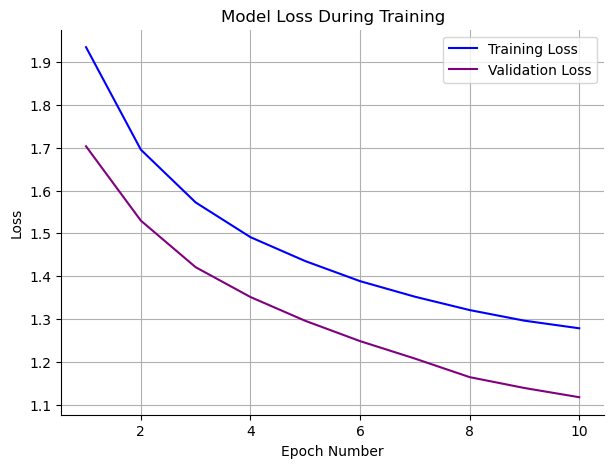

In [11]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [32, 24, 16]
model_32_24_16mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 2.0421376756474943;  Validation Loss: 1.9095605124126782
Epoch 1: Train Loss: 1.9343094674846795;  Validation Loss: 1.8864212794737383
Epoch 2: Train Loss: 1.9035412797444984;  Validation Loss: 1.8527132001790134
Epoch 3: Train Loss: 1.8866702061665208;  Validation Loss: 1.8565796451135115
Epoch 4: Train Loss: 1.859327589409261;  Validation Loss: 1.8312987793575635
Epoch 5: Train Loss: 1.8449283672284476;  Validation Loss: 1.8303010788830845
Epoch 6: Train Loss: 1.832921417453621;  Validation Loss: 1.8242900913411921
Epoch 7: Train Loss: 1.8227220547350147;  Validation Loss: 1.8001027269796892
Epoch 8: Train Loss: 1.8135232306733917;  Validation Loss: 1.8505423123186284
Epoch 9: Train Loss: 1.8100694795198078;  Validation Loss: 1.8089653036811135


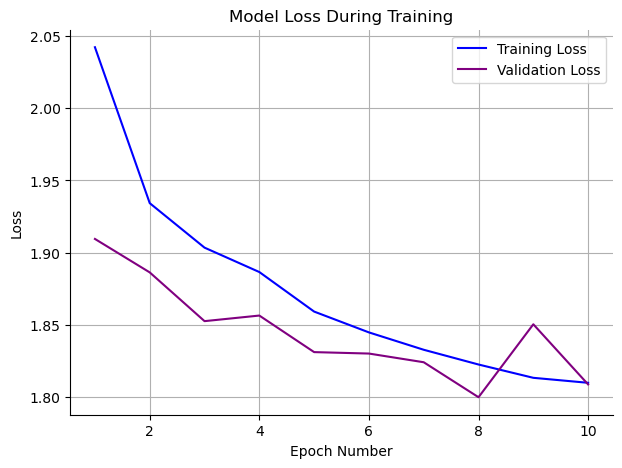

In [12]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [64, 42, 26, 16, 10, 7, 5, 3]
model_64_42_26_16_10_7_5_3, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 1.7398095281818244;  Validation Loss: 1.387675160711462
Epoch 1: Train Loss: 1.341756973085524;  Validation Loss: 1.1108322008089586
Epoch 2: Train Loss: 1.1691063521783562;  Validation Loss: 0.980071718042547
Epoch 3: Train Loss: 1.0767220952842809;  Validation Loss: 0.8945872323079542
Epoch 4: Train Loss: 1.0121098251282414;  Validation Loss: 0.8427580987865274
Epoch 5: Train Loss: 0.9710485248626033;  Validation Loss: 0.80765339596705
Epoch 6: Train Loss: 0.9437278501595123;  Validation Loss: 0.781874341043559
Epoch 7: Train Loss: 0.9231715926641151;  Validation Loss: 0.7615761011838913
Epoch 8: Train Loss: 0.9054048981847642;  Validation Loss: 0.7479223906993866
Epoch 9: Train Loss: 0.892557918270932;  Validation Loss: 0.7227598672563379


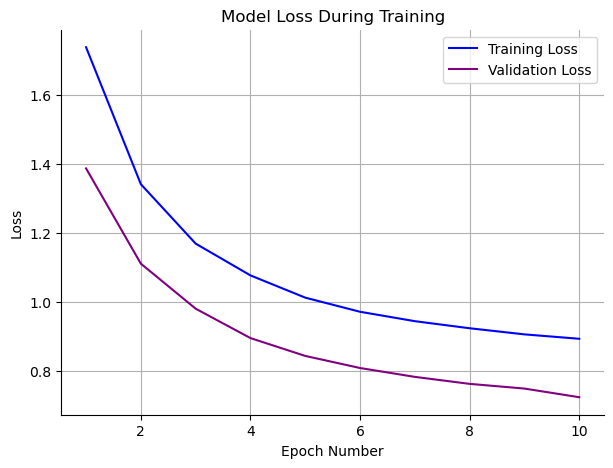

In [13]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [56, 28]
model_56_28mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 1.8786597312251223;  Validation Loss: 1.5641138824549587
Epoch 1: Train Loss: 1.4764720427839062;  Validation Loss: 1.287391267039559
Epoch 2: Train Loss: 1.2688053725640984;  Validation Loss: 1.1102058426900343
Epoch 3: Train Loss: 1.1413084042223194;  Validation Loss: 0.9870824786749753
Epoch 4: Train Loss: 1.0554822019383878;  Validation Loss: 0.8977123282172463
Epoch 5: Train Loss: 0.9938427624823172;  Validation Loss: 0.8326541537588293
Epoch 6: Train Loss: 0.948595569103579;  Validation Loss: 0.781483614986593
Epoch 7: Train Loss: 0.9119292739071424;  Validation Loss: 0.7422695105726068
Epoch 8: Train Loss: 0.8877205358275885;  Validation Loss: 0.7115574953230944
Epoch 9: Train Loss: 0.8674557095841516;  Validation Loss: 0.6857501891526309


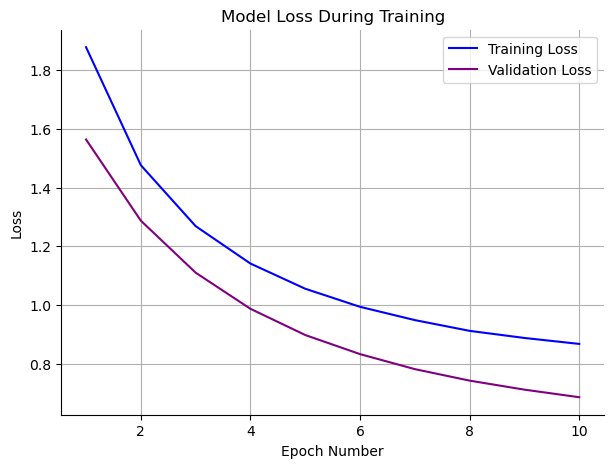

In [14]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [28]
model_28mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 1.772289588481565;  Validation Loss: 1.4329151836308567
Epoch 1: Train Loss: 1.3287069390091715;  Validation Loss: 1.121260030703111
Epoch 2: Train Loss: 1.1053661779512334;  Validation Loss: 0.9434356364336881
Epoch 3: Train Loss: 0.9875684689871872;  Validation Loss: 0.8285697129639712
Epoch 4: Train Loss: 0.9112649288358567;  Validation Loss: 0.7475020262328061
Epoch 5: Train Loss: 0.8559629600259322;  Validation Loss: 0.6848746470429681
Epoch 6: Train Loss: 0.8139012093785443;  Validation Loss: 0.6341099766167727
Epoch 7: Train Loss: 0.7828222445294827;  Validation Loss: 0.5938993340188806
Epoch 8: Train Loss: 0.759019149255149;  Validation Loss: 0.5616861798546531
Epoch 9: Train Loss: 0.7405499514145187;  Validation Loss: 0.5358190401033922


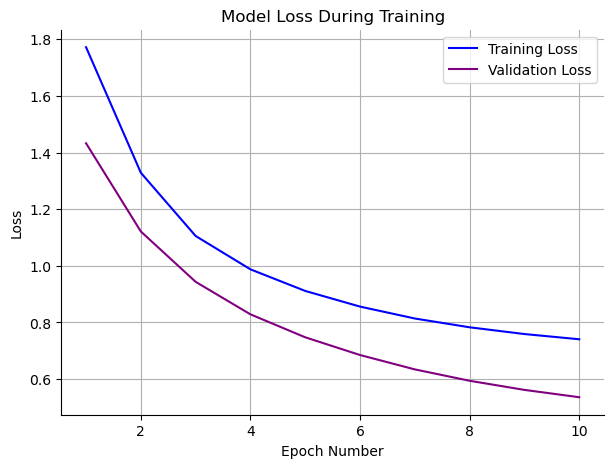

In [15]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [36]
model_, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 1.9592555278464208;  Validation Loss: 1.7339415225115689
Epoch 1: Train Loss: 1.6683253804339637;  Validation Loss: 1.4846078699285334
Epoch 2: Train Loss: 1.4764972185786767;  Validation Loss: 1.3207576112313704
Epoch 3: Train Loss: 1.3491007346141188;  Validation Loss: 1.211519100449302
Epoch 4: Train Loss: 1.2665548294405393;  Validation Loss: 1.1278976770964535
Epoch 5: Train Loss: 1.2040369465381284;  Validation Loss: 1.0606335374442013
Epoch 6: Train Loss: 1.1527005343497554;  Validation Loss: 1.0033456981182098
Epoch 7: Train Loss: 1.1119280691388287;  Validation Loss: 0.9554425044493242
Epoch 8: Train Loss: 1.0763768900798847;  Validation Loss: 0.9144936176863584
Epoch 9: Train Loss: 1.052010386804991;  Validation Loss: 0.8805106390606273


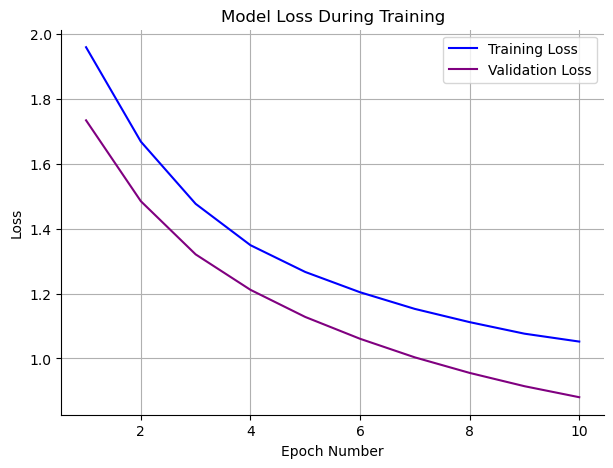

In [16]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [20]
model_20mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 1.8769195275970652;  Validation Loss: 1.6096394766460767
Epoch 1: Train Loss: 1.558939758735367;  Validation Loss: 1.3604217659343372
Epoch 2: Train Loss: 1.3877988389775724;  Validation Loss: 1.2136028571562334
Epoch 3: Train Loss: 1.2818728730648379;  Validation Loss: 1.1069289554249158
Epoch 4: Train Loss: 1.20871461041366;  Validation Loss: 1.0306254571134394
Epoch 5: Train Loss: 1.1583658411533018;  Validation Loss: 0.9775848253206774
Epoch 6: Train Loss: 1.1231598144845119;  Validation Loss: 0.9433650862086903
Epoch 7: Train Loss: 1.0997769455366497;  Validation Loss: 0.9196211451833899
Epoch 8: Train Loss: 1.0804618793197824;  Validation Loss: 0.9029906771399758
Epoch 9: Train Loss: 1.0691912996618054;  Validation Loss: 0.8883591754869982


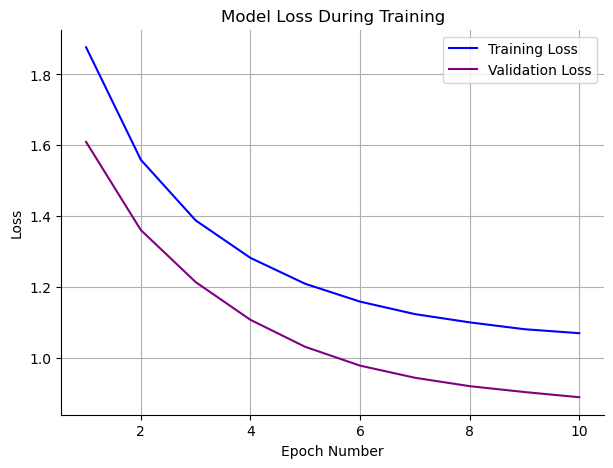

In [17]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [36, 20]
model_36_20mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 1.7326250710064852;  Validation Loss: 1.3799497105858543
Epoch 1: Train Loss: 1.2629223986517024;  Validation Loss: 1.044565287503329
Epoch 2: Train Loss: 1.0387895046910154;  Validation Loss: 0.859225102446296
Epoch 3: Train Loss: 0.9182412073582034;  Validation Loss: 0.7447027834978971
Epoch 4: Train Loss: 0.8420687861080411;  Validation Loss: 0.6669995202259584
Epoch 5: Train Loss: 0.7876539833938019;  Validation Loss: 0.6108180961825631
Epoch 6: Train Loss: 0.7522210327884818;  Validation Loss: 0.5708101947199214
Epoch 7: Train Loss: 0.7251568232910542;  Validation Loss: 0.5377326309680939
Epoch 8: Train Loss: 0.7062367811987672;  Validation Loss: 0.5119047584858808
Epoch 9: Train Loss: 0.6898466627809066;  Validation Loss: 0.49172908338633453


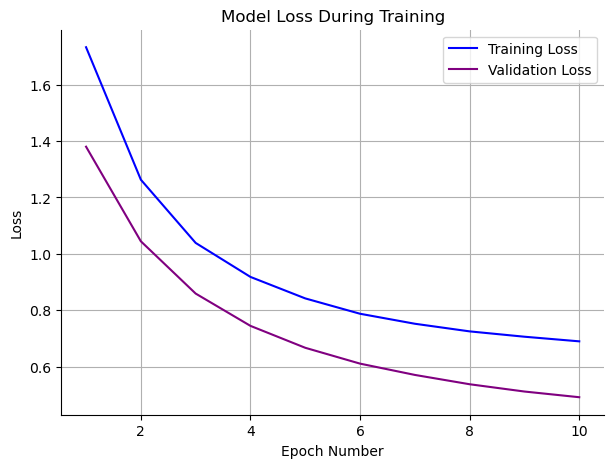

In [18]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [40]
model_40mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 1.9556666929510576;  Validation Loss: 1.7079444039951672
Epoch 1: Train Loss: 1.7084192113031316;  Validation Loss: 1.5021712292324414
Epoch 2: Train Loss: 1.5936431250994718;  Validation Loss: 1.41051324931058
Epoch 3: Train Loss: 1.5107201488712165;  Validation Loss: 1.3193690803917972
Epoch 4: Train Loss: 1.441429645200319;  Validation Loss: 1.2617025565017352
Epoch 5: Train Loss: 1.3958204969575134;  Validation Loss: 1.2154989513483914
Epoch 6: Train Loss: 1.3607690123063099;  Validation Loss: 1.1809175610542297
Epoch 7: Train Loss: 1.3325142377539525;  Validation Loss: 1.152082535353574
Epoch 8: Train Loss: 1.308351353753971;  Validation Loss: 1.1250561692497947
Epoch 9: Train Loss: 1.2943033161042612;  Validation Loss: 1.107305494221774


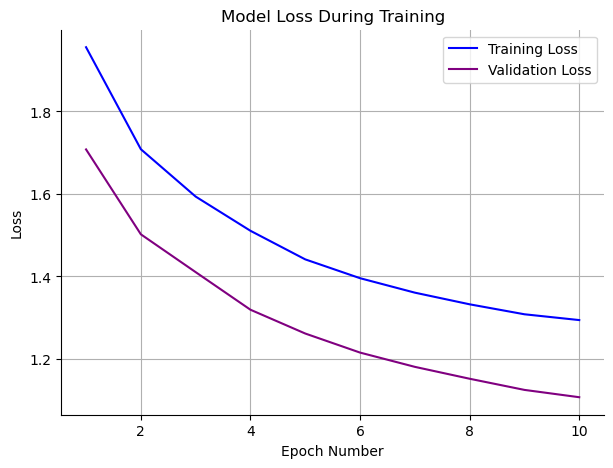

In [19]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [36, 20, 12]
model_36_20_12mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 2.0138431561144094;  Validation Loss: 1.8260097070173784
Epoch 1: Train Loss: 1.777593879760066;  Validation Loss: 1.6336955969983882
Epoch 2: Train Loss: 1.6439573508274705;  Validation Loss: 1.5165427381342107
Epoch 3: Train Loss: 1.5634070408495166;  Validation Loss: 1.44583721594377
Epoch 4: Train Loss: 1.514158295679696;  Validation Loss: 1.3947280645370483
Epoch 5: Train Loss: 1.475315398807767;  Validation Loss: 1.3563325161283666
Epoch 6: Train Loss: 1.4434728546987605;  Validation Loss: 1.3286359960382634
Epoch 7: Train Loss: 1.4240929205206376;  Validation Loss: 1.3041611449284987
Epoch 8: Train Loss: 1.4051385680331459;  Validation Loss: 1.2826219390739093
Epoch 9: Train Loss: 1.3919732796994946;  Validation Loss: 1.2689202671701258


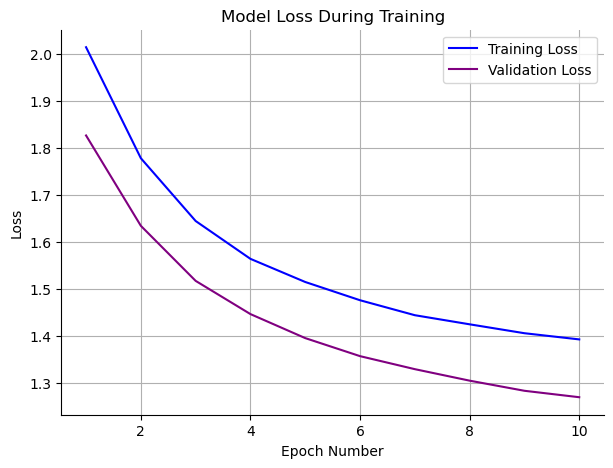

In [20]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [20, 12]
model_20_12mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

In [21]:
assert(False)

AssertionError: 

Save a few of the above models

In [ ]:
torch.save(model_56_28mir.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\RNNAE_56_28mir_vallossp419_BothPCA40.pth')
torch.save(model_56_28_3mir.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\RNNAE_56_28_3mir_valloss1p33_BothPCA40.pth')
torch.save(model_40mir.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\RNNAE_40mir_vallossp29_BothPCA40.pth')

In [ ]:
assert(False)

## Old Grid Search
> Trying a ton of different architectures to find what's best for this dataset!
- Progressive should only be True, only False if nodes are being entered manually
- Not sure if this still works with the most recent version of the model code

In [ ]:
input_dim = 40  # Number of features
seq_len = 64  # Number of timesteps

# Define the parameter grid
param_grid = {
    'hidden_dim': [32, 64, 128],
    'num_layers': [2, 3, 4],
    'progressive': [True]  # Flag to halve the hidden units for each successive layer
}

# Run grid search
best_model, best_params = grid_search_rnn_autoencoder(train_loader, test_loader, input_dim, seq_len, param_grid)

- Trial: 0;: {'hidden_dim': 32, 'num_layers': 2, 'progressive': True}, Validation Loss: 0.02083
- 4- 
Trial: 1s: {'hidden_dim': 32, 'num_layers': 2, 'progressive': False}, Validation Loss: 0.016
- 3- 35
Trial:ams: {'hidden_dim': 32, 'num_layers': 3, 'progressive': True}, Validation Loss: 0.0
- 7- 5635
Triaarams: {'hidden_dim': 32, 'num_layers': 3, 'progressive': False}, Validation Loss: 0
- 5- 940434
Tr
Params: {'hidden_dim': 32, 'num_layers': 4, 'progressive': True}, Validation Loss:
- 7- 31617157 e
Params: {'hidden_dim': 32, 'num_layers': 4, 'progressive': False}, Validation Los
- 0- 6267585271rue
Params: {'hidden_dim': 64, 'num_layers': 2, 'progressive': True}, Validation Lo
- 8- 4156883282False
Params: {'hidden_dim': 64, 'num_layers': 2, 'progressive': False}, Validation 
- 5- 4547723424e: True
Params: {'hidden_dim': 64, 'num_layers': 3, 'progressive': True}, Validati
- 2- 2054176014ve: False
Params: {'hidden_dim': 64, 'num_layers': 3, 'progressive': False}, Valida
- .- 01182716042ssive: True
Params: {'hidden_dim': 64, 'num_layers': 4, 'progressive': True}, Vali
- :-  0.04446715essive: False
Params: {'hidden_dim': 64, 'num_layers': 4, 'progressive': False}, Va
- s- : 0.0171945ogressive: True
Params: {'hidden_dim': 128, 'num_layers': 2, 'progressive': True}, 
- s- s: 0.002466rogressive: False
Params: {'hidden_dim': 128, 'num_layers': 2, 'progressive': False}
- L- oss: 0.0017; progressive: True
Params: {'hidden_dim': 128, 'num_layers': 3, 'progressive': Tru
- o- n Loss: 0.03; progressive: False
Params: {'hidden_dim': 128, 'num_layers': 3, 'progressive': Fa
- t- ion Loss: 0s: 4; progressive: True
Params: {'hidden_dim': 128, 'num_layers': 4, 'progressive'5
- d- ation Loss:rs: 4; progressive: False
Params: {'hidden_dim': 128, 'num_layers': 4, 'progressive
- l- idation Loss: 0.010927938756399922
Best Params: {'hidden_dim': 128, 'num_layers': 2, 'progressive': Fallidation Loss: 0.0017131721086079037


__Best model from above:__ <br>
Trial: 13; hidden_dim: 128; num_layers: 2; progressive: False <br>
Params: {'hidden_dim': 128, 'num_layers': 2, 'progressive': False}, Validation Loss: 0.0017131721086079037

In [ ]:
torch.save(best_model.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\RNNAE_latent128_progFalse_numlayers2_trial13_vallossp001_BothPCA40.pth')

In [ ]:
assert(False)

# Temporal Convolution Autoencoder

In [ ]:
# This one is different but not sure what the effect is...
## Observed a higher starting loss, only sort of converged, loss only somewhat decreased
#class TCNEncoder(nn.Module):
#    def __init__(self, input_dim, hidden_dim, kernel_size):
#        super(TCNEncoder, self).__init__()
#        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=kernel_size//2, stride=2)  # Adjusted stride
#        
#    def forward(self, x):
#        x = x.permute(0, 2, 1)
#        x = torch.relu(self.conv1(x))
#        return x

class TCNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(TCNEncoder, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=kernel_size//2)
        self.pool = nn.MaxPool1d(2)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        return x

class TCNDecoder(nn.Module):
    def __init__(self, hidden_dim, output_dim, kernel_size):
        super(TCNDecoder, self).__init__()
        self.conv1 = nn.ConvTranspose1d(hidden_dim, hidden_dim, kernel_size, stride=2, padding=kernel_size//2, output_padding=1)  # Adjusted to maintain dimensions
        self.conv2 = nn.Conv1d(hidden_dim, output_dim, kernel_size=1)  # Convolution to adjust channels if needed

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))  # Apply activation after the final convolution
        x = x.permute(0, 2, 1)  # Permute dimensions to match the desired output size
        return x

class TCNAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(TCNAutoencoder, self).__init__()
        self.encoder = TCNEncoder(input_dim, hidden_dim, kernel_size)
        self.decoder = TCNDecoder(hidden_dim, input_dim, kernel_size)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
        

In [ ]:
# Hyperparameters
input_dim = 40
hidden_dim = 64
kernel_size = 5
num_epochs = 10
learning_rate = 0.001

# Model, Loss, and Optimizer
temp_conv_ae_model = TCNAutoencoder(input_dim, hidden_dim, kernel_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(temp_conv_ae_model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        output = temp_conv_ae_model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    

# Varitational Autoencoder

## PP

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Encoder Network
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        _, hidden = self.rnn(x)
        hidden = hidden.squeeze(0)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

# Decoder Network
class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.fc_hidden = nn.Linear(latent_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, z):
        hidden = self.fc_hidden(z).unsqueeze(0)
        output, _ = self.rnn(hidden)
        output = self.fc_output(output)
        return output

# Variational Autoencoder
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, output_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, hidden_size, output_size)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001
latent_size = 16
hidden_size = 64

# Create data loader
#train_loader = torch.utils.data.DataLoader(dummy_data, batch_size=batch_size, shuffle=True)

# Loss function
reconstruction_loss = nn.MSELoss(reduction='sum')

In [ ]:
# Initialize VAE model
input_size = 40
output_size = 40
vae = VAE(input_size, hidden_size, latent_size, output_size)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)


In [ ]:
# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in train_loader:
        #print(type(batch))
        #print(batch.shape)
        #batch = batch.view(-1, 64, 40)  # Reshape batch for RNN input
        optimizer.zero_grad()

        # Forward pass
        x_recon, mu, logvar = vae(batch)
        print(type(x_recon))
        print(x_recon.shape)
        # Reconstruction loss
        recon_loss = reconstruction_loss(x_recon, batch)
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Total loss
        loss = recon_loss + kl_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader.dataset):.4f}")

# Save the trained model
#torch.save(vae.state_dict(), 'vae_model.pth')

## Jackson Kang

In [ ]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)#.to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [ ]:
# Hyperparameters
batch_size = 32
epochs = 10
lr = 0.001

latent_dim = 16
hidden_dim = 64
x_dim = 40


In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = VAE(Encoder=encoder, Decoder=decoder)#.to(DEVICE)

In [ ]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    #for batch_idx, (x, _) in enumerate(train_loader):
    for batch_idx, (x) in enumerate(train_loader):
        #x = x.view(batch_size, x_dim)
        x = x.view(batch_size, hidden_dim, x_dim)
        #x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

## CG

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, use_xavier_init=True):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim*2)  # mean and logvar
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

        # Initialize weights using Xavier initialization
        if use_xavier_init:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    torch.nn.init.xavier_uniform_(m.weight)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD


In [ ]:
print("Starting")

# Hyperparameters
#input_dim = data.size(1) * data.size(2)
input_dim = 64 * 40
hidden_dim = 128
latent_dim = 32
num_epochs = 50
learning_rate = 0.001

# Model, Loss, and Optimizer
vae_model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae_model(batch)
        loss = vae_model.loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
torch.save(vae_model.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\BrokenVAE_hidden128_latent32_NegativeLossesLol.pth')

# Sparse Autoencoder

In [ ]:
# ONE LAYER SparseAE

class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        encoded = self.relu(self.encoder(x))
        decoded = self.sigmoid(self.decoder(encoded))
        return decoded

In [ ]:
input_dim = 40
hidden_dim = 12
num_epochs = 20
learning_rate = 0.001

# Model, Loss, and Optimizer
sparse_ae_model = SparseAutoencoder(input_dim, hidden_dim)
optimizer = optim.Adam(sparse_ae_model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        output = sparse_ae_model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
torch.save(sparse_ae_model.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\SparseAE_latent12_onelayer_conv_trainlossp08.pth')

In [ ]:
# N LAYER SparseAE
## NOT WORKING YET

class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(SparseAutoencoder, self).__init__()
        if type(hidden_dims) is int:
            hidden_dims = list(hidden_dims)
        
        # Encoder layers
        encoder_layers = []
        for i in range(len(hidden_dims) - 1):
            encoder_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder layers
        decoder_layers = []
        for i in range(len(hidden_dims) - 1, 0, -1):
            decoder_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i-1]))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(hidden_dims[0], input_dim))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)
        self.output_layer = nn.Linear(hidden_dims[-1], input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        output = self.output_layer(decoded)
        return decoded

In [ ]:
input_dim = 40
hidden_dim_lst = [3]
num_epochs = 20
learning_rate = 0.001

# Model, Loss, and Optimizer
sparse_ae_model = SparseAutoencoder(input_dim, hidden_dim_lst)
optimizer = optim.Adam(sparse_ae_model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        output = sparse_ae_model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Denoising Autoencoder

In [ ]:
# ONE LAYER DenoisingAE

class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        encoded = self.relu(self.encoder(x))
        decoded = self.sigmoid(self.decoder(encoded))
        return decoded

    def add_noise(self, x, noise_level=0.1):
        # Add Gaussian noise to the input
        noise = torch.randn_like(x) * noise_level
        return x + noise

In [ ]:
input_dim = 40
hidden_dim = 12
num_epochs = 20
learning_rate = 0.001

# Model, Loss, and Optimizer
denoising_ae_model = DenoisingAutoencoder(input_dim, hidden_dim)
optimizer = optim.Adam(denoising_ae_model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        output = denoising_ae_model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
torch.save(denoising_ae_model.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\denoisingAE_flatconv_onelayer_latent12.pth')